# setup

In [0]:
# packages
!pip install adjustText
!pip install gif
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import trange, tqdm
import gif
from adjustText import adjust_text

In [0]:
# other setup
projdir = "drive/My Drive/CPCB 1/cellsys/"
timeptdir = "04_30_2020___CSV_SimulatedData"
Path("plots").mkdir(parents=True, exist_ok=True)
plt.rcParams['savefig.bbox'] = 'tight' 

In [0]:
# get data
!unzip "drive/My Drive/CPCB 1/cellsys/04_30_2020___CSV_SimulatedData.zip"

# cluster

In [0]:
fn = timeptdir+"/Timepoint_60.csv"
finaldf = pd.read_csv(fn,index_col=0)

In [0]:
import re
infodf = pd.DataFrame(
    [re.split('_|\.',s) for s in finaldf.index], 
    index=finaldf.index,
    columns=["type","prod1","prod2","filetype"])

### subsetdfbynums

In [0]:
def subsetdfbynums(numlist, df, info, exclude=True):
  """
  Subset the output by the names of the proteins that are swapped.
  """
  strexc = [str(n) for n in numlist]
  idx = info.index[infodf['prod1'].isin(strexc)] | info.index[info['prod2'].isin(strexc)]
  mask = df.index.isin(idx)
  if exclude == True:
    return df[~mask]
  else:
    return df[mask]

### clust_sil

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.ticker as mticker

def clust_sil(X, title=None, pngfn=None):
  """
  Plots Silhouette score for a varying number of clusters.
  The 'optimal' number of clusters is the peak value.
  """
  nclustlist = []
  scorelist = []
  n_samples = X.shape[0]
  for nclust in range(2,min(n_samples - 1,21)):
    clusterer = KMeans(nclust, init='k-means++', random_state=0)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    nclustlist.append(nclust)
    scorelist.append(score)

  ax = sns.scatterplot(x=nclustlist, y=scorelist)
  ax.set(xlabel='Number of clusters', ylabel='Silhouette score')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
  if title is None:
    title = 'Optimal number of k-means clusters'
  plt.title(title)
  if pngfn is not None:
    plt.savefig(pngfn)
  plt.show()

### reduce, k_means_cluster, get_clust_count

In [0]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def reduce(X, dims=2):
  """
  Dimensionality reduction via PCA.
  Returns: reduced representation, fitted PCA
  """
  pca = PCA(n_components=dims)
  X_reduced = pca.fit_transform(X)
  redcolnames = ["PC"+str(i+1) for i in range(0,dims)]
  X_reduced = pd.DataFrame(data=X_reduced,index=X.index,columns=redcolnames)
  return X_reduced, pca

def k_means_cluster(data, n_clusters = 10):
  """
  K-means clustering.
  Returns: labels
  """
  clusterer = KMeans(n_clusters, init='k-means++', random_state=0)
  kmeans = clusterer.fit(data)
  return np.array(kmeans.labels_)

from collections import Counter, defaultdict
def get_clust_count(labels):
  """
  Returns cluster label counts.
  """
  return Counter(labels)

### plotnumpc

In [0]:
# number of components
from sklearn.decomposition import PCA
import matplotlib.ticker as mticker

def plotnumpc(data):
  """
  Plots fraction of variance explained for each principal component.
  """
  nc = min(data.shape)
  nc = min(20,nc)
  pcaobj = PCA(n_components=nc)
  pcaobj.fit(data)
  print(np.arange(1,nc+1).shape)
  print(pcaobj.explained_variance_ratio_.shape)
  ax = sns.scatterplot(x=np.arange(1,nc+1),y=pcaobj.explained_variance_ratio_)
  ax.set(xlabel='Number of principal components', ylabel='Proportion')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Percentage of variance explained')
  plt.show()

### subcluster

In [0]:
# @gif.frame
def subcluster(df, info, excludenums, k, dims=2, pcx=1, pcy=2, negpcx=False,
               labs=None, 
               plotlabels=False, figsize=None, title=None, 
               ylim=(None,None), xlim=(None,None), pngfn=None,
               makeplot=True, verbose=True, pltshow=True, justplot=False):
  """
  Subsets and clusters the data, plots PCA.
  """
  if pngfn == "":
    Path("plots").mkdir(parents=True, exist_ok=True)
    pngfn = "plots/pcplot"+\
      "_exc_"+"-".join([str(x) for x in excludenums])+\
      "_dims-"+str(dims)+\
      "_k-"+str(k)+\
      ".png"
  # subset and reduce data
  pcxstr = "PC"+str(pcx)
  pcystr = "PC"+str(pcy)
  subdf = subsetdfbynums(excludenums, df, info)
  reduced, pcares = reduce(subdf, dims=dims)
  # clustering labels
  if labs is None:
    labs = k_means_cluster(reduced, k)
  if verbose == True: print(get_clust_count(labs))
  if makeplot != True:
    return labs, subdf, reduced
  dfplot = reduced
  # switch the PC direction if specified
  if negpcx == True:
    dfplot[pcxstr] = -1*dfplot[pcxstr]
  if verbose == True: print(dfplot.shape)
  dfplot['label'] = labs
  # plot
  if figsize is not None:
    plt.figure(figsize=figsize)
  ax = sns.scatterplot(
      x=pcxstr,
      y=pcystr,
      hue="label",
      # hue = "dataset",
      palette="muted",
      # legend="full",
      data=dfplot
  )
  ax.set_ylim(ylim)
  ax.set_xlim(xlim)
  # legend
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  # data point labels
  if plotlabels == True:
    texts = [plt.text(dfplot[pcxstr][i], dfplot[pcystr][i], re.sub("\.m|Swap_","",dfplot.index[i]), 
                      ha='center', va='center') for i in range(0,dfplot.shape[0])]
    adjust_text(texts)
  # plot title
  if title is not None:
    plt.title(title)
  if pngfn is not None:
    plt.savefig(pngfn,bbox_inches='tight')
  # whether or not to show plot
  if pltshow == True:
    plt.show()
  else:
    plt.clf()
  # whether or not to return other info
  if justplot == False:
    return labs, subdf, reduced

# phage bar plot

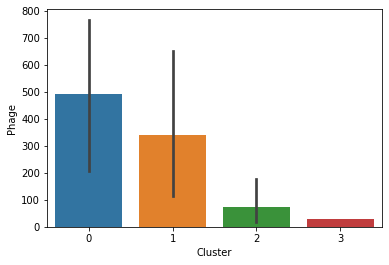

In [0]:
dfplot = pd.DataFrame()
dfplot['Phage'] = s['Phage']
dfplot['Cluster'] = lablist[1]
sns.barplot(x="Cluster",y="Phage",data=dfplot)

# normalization

In [0]:
def normalizedf(df, method):
  if method == "mean":
    normalized_df=(df-df.mean())/df.std()
  elif method == "minmax":
    normalized_df=(df-df.min())/(df.max()-df.min())
  normalized_df[normalized_df < 1e-10] = 0
  return normalized_df

In [0]:
normdfdict = {k:normalizedf(finaldf,method=k) for k in ["mean","minmax"]}

## num pcs

(17,)
(17,)


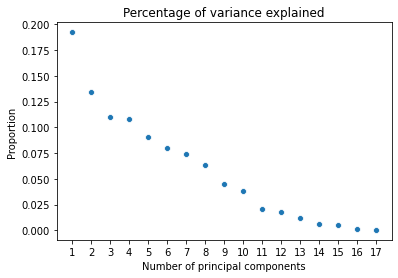

(17,)
(17,)


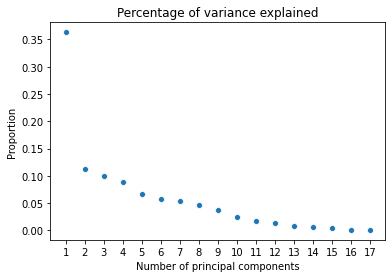

In [0]:
plotnumpc(normdfdict["mean"])
plotnumpc(normdfdict["minmax"])

## check cluster numbers

excluding: []
mean


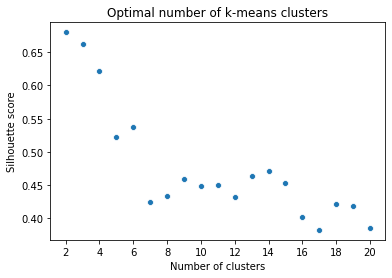

minmax


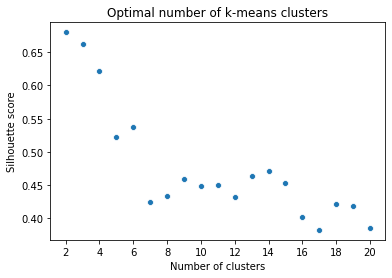

excluding: [2, 10, 1, 11]
mean


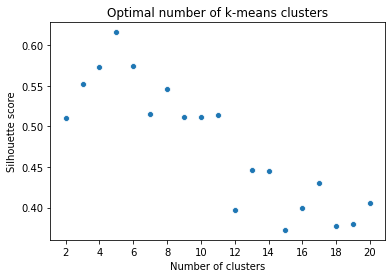

minmax


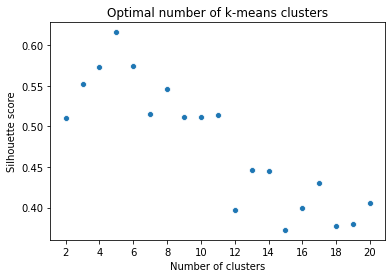

In [0]:
exc = [[],
       [2,10,1,11]]
subdf = []
for i in range(len(exc)):
  print("excluding:",exc[i])
  # mean
  print("mean")
  subdf.append(subsetdfbynums(exc[i], normalizedf(finaldf,method="mean"), infodf))
  toclust = reduce(subdf[i],4)[0]
  # toclust = subdf[i]
  clust_sil(toclust)

  # minmax
  print("minmax")
  subdf.append(subsetdfbynums(exc[i], normalizedf(finaldf,method="minmax"), infodf))
  toclust = reduce(subdf[i],4)[0]
  # toclust = subdf[i]
  clust_sil(toclust)

## cluster

% excluding: []
original
Counter({2: 28, 0: 12, 1: 7})
(47, 4)


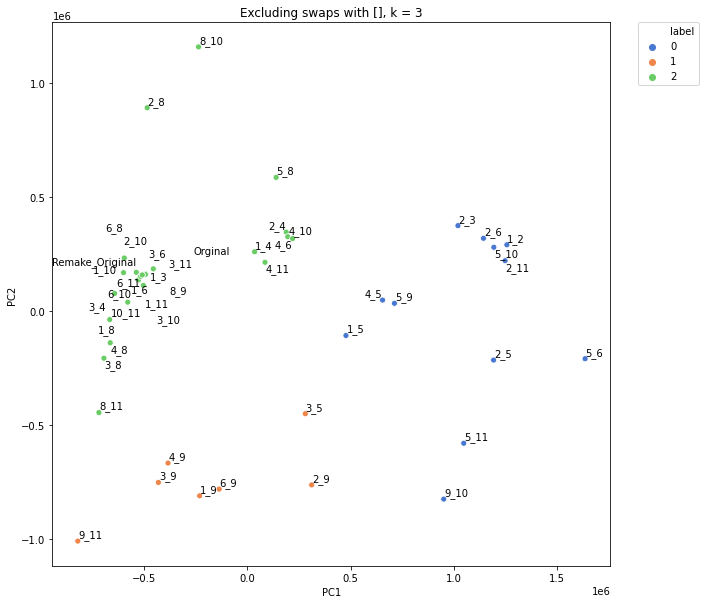

mean
Counter({0: 43, 1: 2, 2: 2})
(47, 4)


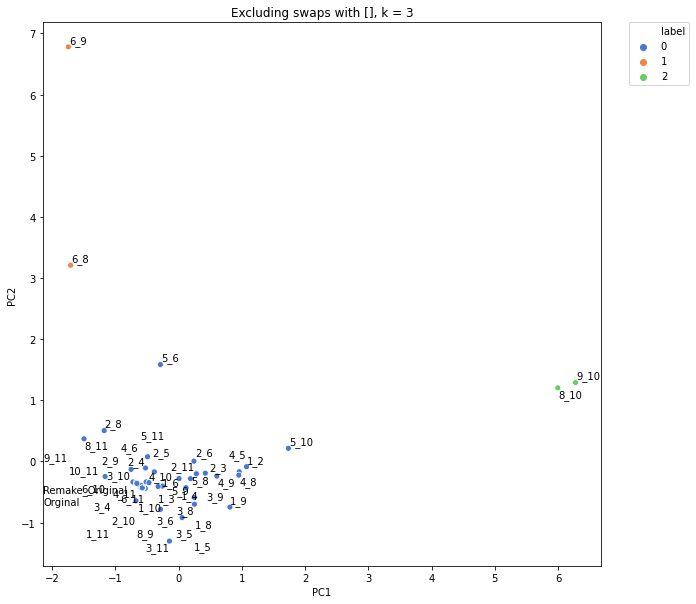

minmax
Counter({1: 21, 2: 21, 0: 5})
(47, 4)


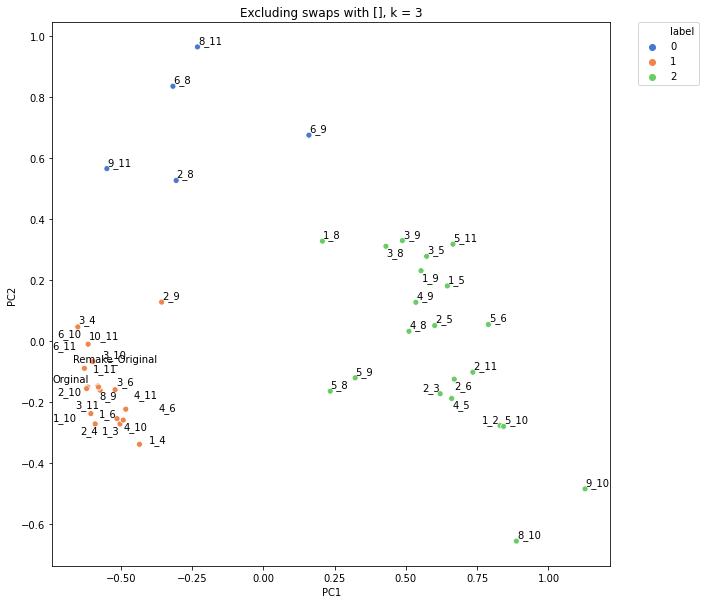

% excluding: [2, 10, 1, 11]
original
Counter({0: 8, 1: 3, 2: 3, 3: 2, 4: 1})
(17, 4)


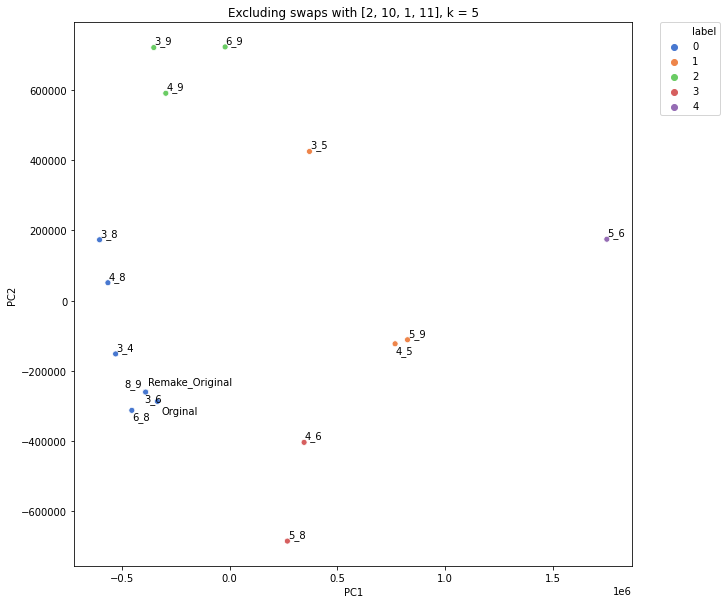

mean
Counter({0: 10, 1: 4, 3: 1, 4: 1, 2: 1})
(17, 4)


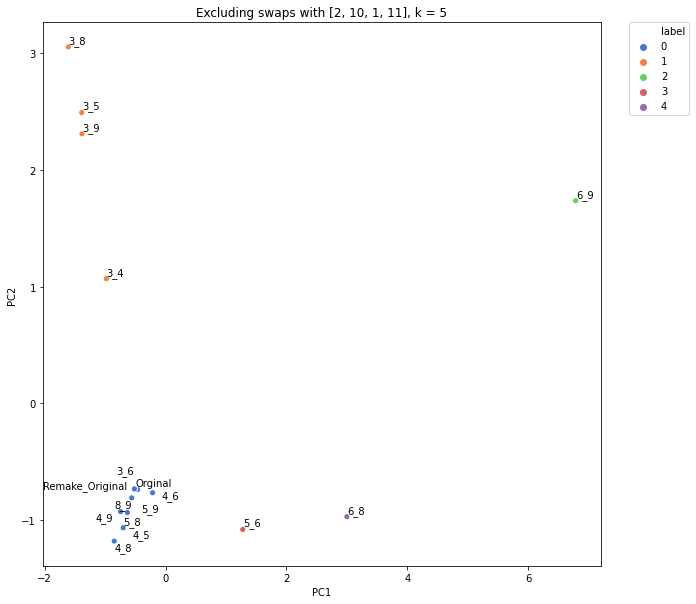

minmax
Counter({1: 6, 0: 5, 2: 3, 4: 2, 3: 1})
(17, 4)


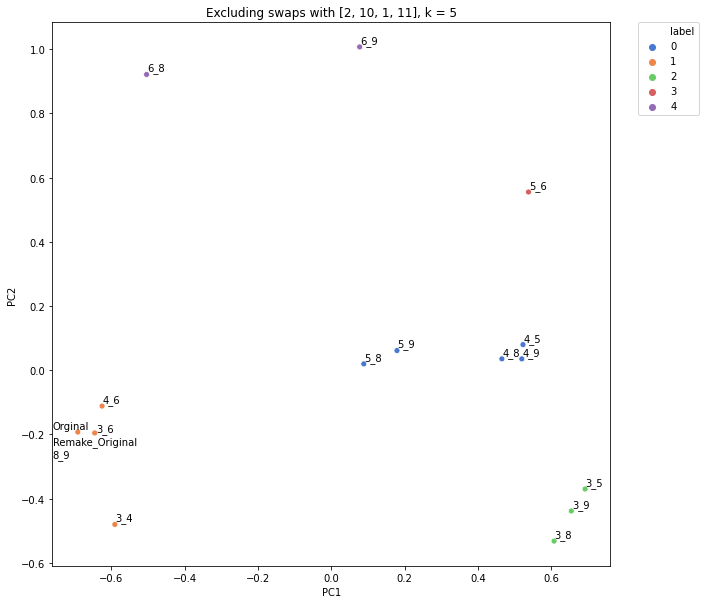

In [0]:
klist = [3,5]
titlelist = ["Excluding swaps with "+str(exc[i])+", k = "+str(klist[i]) for i in range(len(exc))]
for i in range(len(exc)):
  print("% excluding:",exc[i])
  print("original")
  subcluster(finaldf, infodf, exc[i], klist[i], dims=4, title=titlelist[i], 
             plotlabels=True,figsize=(10,10),
             justplot=True)
  print("mean")
  subcluster(normalizedf(finaldf,method="mean"), infodf, exc[i], klist[i], dims=4, title=titlelist[i], 
             plotlabels=True,figsize=(10,10),
             justplot=True)
  print("minmax")
  subcluster(normalizedf(finaldf,method="minmax"), infodf, exc[i], klist[i], dims=4, title=titlelist[i], 
             plotlabels=True,figsize=(10,10),
             justplot=True)

## bar plot

In [0]:
for i in range(len(exc)):
  dfplot = pd.DataFrame()
  dfplot['Phage'] = subdflist[i]['Phage']
  dfplot['Cluster'] = lablist[i]
  sns.barplot(x="Cluster",y="Phage",data=dfplot)
  plt.title(titlelist[i])
  plt.show()

# time points

## as features

### file processing

In [0]:
print(timeptdir)

04_30_2020___CSV_SimulatedData


In [0]:
'''
Combine the files into one CSV.
'''

import os
import glob
from natsort import natsorted, ns

# match pattern 'csv'
all_filenames = [i for i in glob.glob(timeptdir+'/*.{}'.format('csv'))]
all_filenames = natsorted(all_filenames, alg=ns.IGNORECASE)
# read in csv
all_csv = [pd.read_csv(f,index_col=0) for f in all_filenames ]
# prepend fn to colnames
for i in range(len(all_csv)):
  df = all_csv[i]
  prefix = os.path.splitext(os.path.basename(all_filenames[i]))[0]
  df.columns = [prefix+"_"+cn for cn in df.columns]
# concatenate
combined_csv = pd.concat(all_csv,axis='columns')
# export to csv
combined_csv.to_csv( "combined_asfeatures.csv")

# get basenames
all_basenames = [os.path.splitext(os.path.basename(n))[0] for n in all_filenames]

# get dataframe with all time points as features
finaldf = pd.read_csv("combined_asfeatures.csv",index_col=0)

### num pcs

(17,)
(17,)


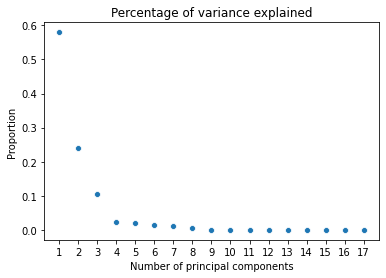

(17,)
(17,)


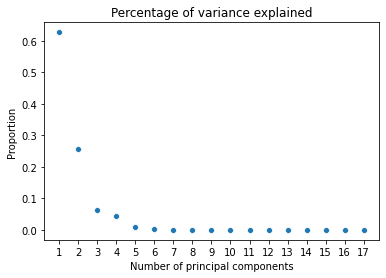

In [0]:
plotnumpc(subdf[0])
plotnumpc(subdf[1])

### silhouette

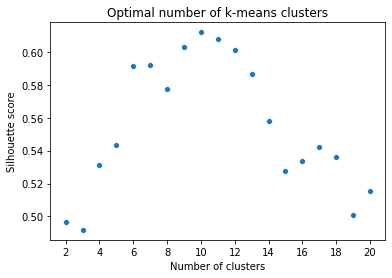

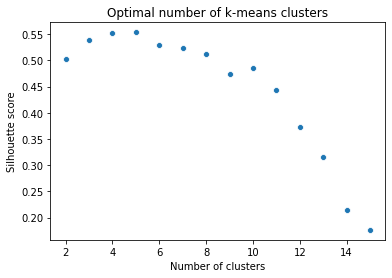

In [0]:
# get number of clusters
exc = [[],
       [2,10,1,11]]
subdf = []
for i in range(len(exc)):
  subdf.append(subsetdfbynums(exc[i], finaldf, infodf))
  toclust = reduce(subdf[i],2)[0]
  # toclust = subdf[i]
  clust_sil(toclust)

### pc plot

% excluding: []
Counter({0: 16, 4: 9, 1: 5, 2: 5, 7: 4, 3: 4, 6: 2, 5: 2})
(47, 2)


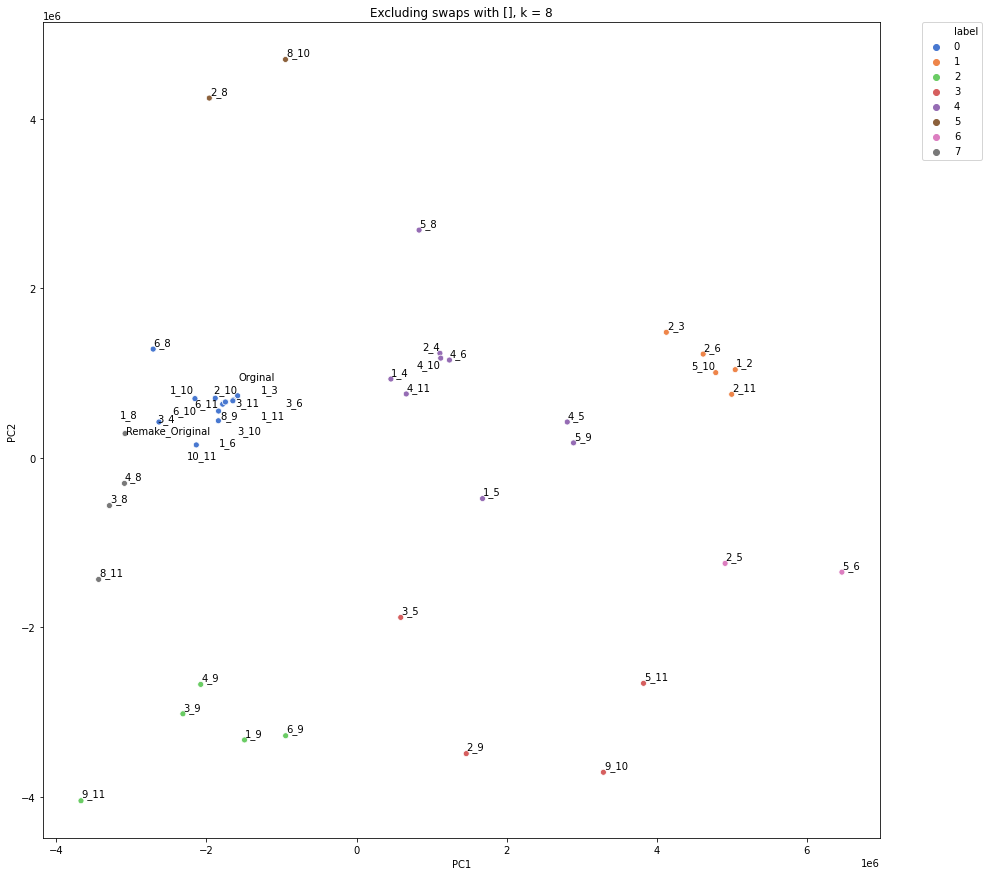

% excluding: [2, 10, 1, 11]
Counter({0: 8, 2: 4, 1: 2, 4: 2, 3: 1})
(17, 2)


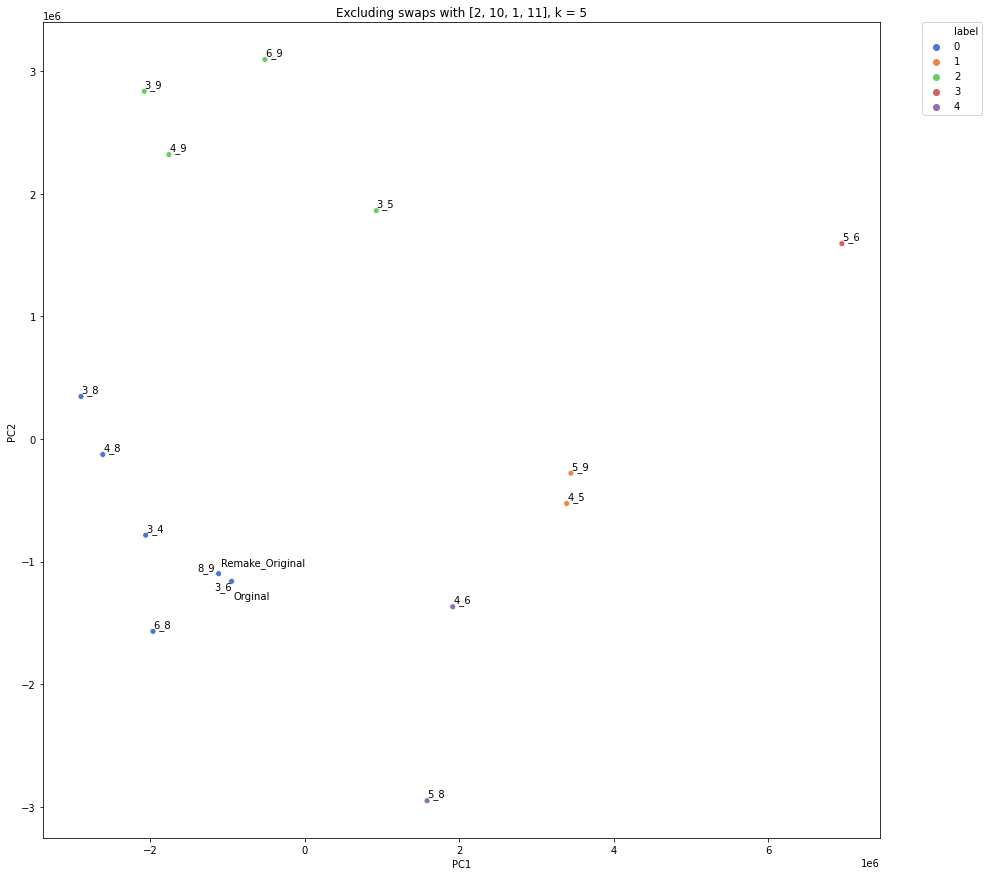

In [0]:
exc = [[],
       [2,10,1,11]]
klist = [8,5]
lablist = []
subdflist = []
titlelist = ["Excluding swaps with "+str(exc[i])+", k = "+str(klist[i]) for i in range(len(exc))]
for i in range(len(exc)):
  print("% excluding:",exc[i])
  l, s, r = subcluster(finaldf, infodf, exc[i], klist[i], dims=2, title=titlelist[i], plotlabels=True, figsize=(15,15))
  lablist.append(l)
  subdflist.append(s)

### pairwise distances

In [0]:
dfpairwise = pd.DataFrame(
    [re.split('_|\.',s) for s in r.index], 
    index=r.index,
    columns=["type","prod1","prod2","filetype"])
dfpairwise = pd.concat([dfpairwise,r.copy()],axis=1)
dfpairwise = dfpairwise[2:]
dfpairwise

,type,prod1,prod2,filetype,PC1,PC2,label
Row,,,,,,,
Swap_3_4.m,Swap,3,4,m,-2.061725e+06,-7.842132e+05,0
Swap_3_5.m,Swap,3,5,m,9.239870e+05,1.863352e+06,2
Swap_3_6.m,Swap,3,6,m,-1.117655e+06,-1.098591e+06,0
Swap_3_8.m,Swap,3,8,m,-2.900019e+06,3.473360e+05,0
Swap_3_9.m,Swap,3,9,m,-2.080630e+06,2.836996e+06,2
Swap_4_5.m,Swap,4,5,m,3.389536e+06,-5.257690e+05,1
Swap_4_6.m,Swap,4,6,m,1.914188e+06,-1.368409e+06,4
Swap_4_8.m,Swap,4,8,m,-2.617801e+06,-1.260882e+05,0
Swap_4_9.m,Swap,4,9,m,-1.761503e+06,2.320501e+06,2


In [0]:
plist = set(dfpairwise['prod1']).union(set(dfpairwise['prod2']))
plist = list(plist)
points = {k:[] for k in plist}
for index,row in dfpairwise.iterrows():
  # add points to their respective groups
  points[row['prod1']].append(np.array([row['PC1'],row['PC2']]))
  points[row['prod2']].append(np.array([row['PC1'],row['PC2']]))
# make numpy matrix
for k in points.keys():
  points[k] = np.array(points[k])

In [0]:
# calculate average pairwise distance for all proteins
avgdist = {k:np.nan for k in points.keys()}
for k in points.keys():
  # calculate distance matrix
  distmat = pairwise_distances(points[k],metric='euclidean')
  avgdist[k] = np.nanmean(np.where(distmat!=0,distmat,np.nan))
avgdist

{'3': 2985226.743299194,
 '4': 3956039.3157012537,
 '5': 3933686.3656676696,
 '6': 5355405.613060364,
 '8': 2702729.1033677263,
 '9': 3743188.641032034}

Text(0.5, 1.0, 'Average pairwise distance between swaps')

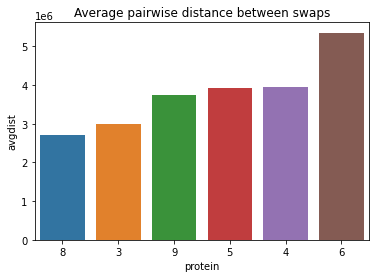

In [0]:
dfplot = pd.DataFrame(columns=['protein','avgdist'],index=avgdist.keys())
for k in avgdist.keys():
  dfplot.loc[k] = [int(k),avgdist[k]]
ax = sns.barplot(x="protein",y="avgdist",data=dfplot,order=dfplot['protein'][dfplot['avgdist'].argsort()])
plt.title("Average pairwise distance between swaps")

### print clusters for matlab

In [0]:
print(exc)
print(klist)

[[], [2, 10, 1, 11]]
[8, 5]


In [0]:
for i in range(len(exc)):
  print("% excluding:",exc[i])
  l, s, r = subcluster(finaldf, infodf, exc[i], klist[i], dims=2, makeplot=False, verbose=False)
  k = klist[i]
  for clustnum in range(k):
    print("% cluster number:",clustnum)
    clust = list(filter(lambda x: x[1] == clustnum, enumerate(l)))
    clust_ind = [kv[0] for kv in clust]
    clust_names = ",".join(['\"'+x+'\"' for x in s.index[clust_ind]])
    print("list = [",clust_names,"];",sep='')
  print("% =================================================================")

% excluding: []
% cluster number: 0
list = ["Orginal","RemakeOrginal.m","Swap_10_11.m","Swap_1_10.m","Swap_1_11.m","Swap_1_3.m","Swap_1_6.m","Swap_2_10.m","Swap_3_10.m","Swap_3_11.m","Swap_3_4.m","Swap_3_6.m","Swap_6_10.m","Swap_6_11.m","Swap_6_8.m","Swap_8_9.m"];
% cluster number: 1
list = ["Swap_1_2.m","Swap_2_11.m","Swap_2_3.m","Swap_2_6.m","Swap_5_10.m"];
% cluster number: 2
list = ["Swap_1_9.m","Swap_3_9.m","Swap_4_9.m","Swap_6_9.m","Swap_9_11.m"];
% cluster number: 3
list = ["Swap_2_9.m","Swap_3_5.m","Swap_5_11.m","Swap_9_10.m"];
% cluster number: 4
list = ["Swap_1_4.m","Swap_1_5.m","Swap_2_4.m","Swap_4_10.m","Swap_4_11.m","Swap_4_5.m","Swap_4_6.m","Swap_5_8.m","Swap_5_9.m"];
% cluster number: 5
list = ["Swap_2_8.m","Swap_8_10.m"];
% cluster number: 6
list = ["Swap_2_5.m","Swap_5_6.m"];
% cluster number: 7
list = ["Swap_1_8.m","Swap_3_8.m","Swap_4_8.m","Swap_8_11.m"];
% =================================================================
% excluding: [2, 10, 1, 11]
% cluster number:

## over time

### silhouette

In [0]:
# decorate a Matplotlib plot function with gif.frame
@gif.frame
def clust_sil(X, title=None, pltshow=True):
  nclustlist = []
  scorelist = []
  n_samples = X.shape[0]
  for nclust in range(2,min(n_samples - 1,21)):
    clusterer = KMeans(nclust, init='k-means++', random_state=0)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    nclustlist.append(nclust)
    scorelist.append(score)

  ax = sns.scatterplot(x=nclustlist, y=scorelist)
  ax.set(xlabel='Number of clusters', ylabel='Silhouette score')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
  if title is None:
    title = 'Optimal number of k-means clusters'
  plt.title(title)
  if pltshow == True:
    plt.show()

In [0]:
# Build a bunch of "frames" with a standard for loop:
frames = []
for i in trange(len(all_filenames)):
  df = pd.read_csv(all_filenames[i],index_col=0)
  s = subsetdfbynums(exc[1],df,infodf)
  toclust = reduce(s,2)[0]
  frame = clust_sil(toclust,title=all_basenames[i],pltshow=False)
  frames.append(frame)

In [0]:
# Select the duration (milliseconds) between each frame and save:
gif.save(frames, "silhouette_sub.gif", duration=2000)

### clusters

In [0]:
print(exc)
print(klist)

[[], [2, 10, 1, 11]]
[8, 5]


In [0]:
frames = []
titlelist = ["Excluding swaps with "+str(exc[i])+", k = "+str(klist[i]) for i in range(len(exc))]
axlimlist = [{"x":(-1e6,1.7e6),
              "y":(-1.1e6,1.3e6)},
             {"x":(-0.7e6,1.8e6),
              "y":(-8e5,8e5)}
             ]
axswaplist = [np.concatenate([np.arange(0,3),np.arange(8,19)]),
              np.arange(0,12)]
excidx = 1
for i in trange(len(all_filenames)):
  df = pd.read_csv(all_filenames[i],index_col=0)
  negx = i in axswaplist[excidx]
  frame = subcluster(df, infodf, exc[excidx], klist[excidx], 
                     dims=2, negpcx=negx,
                     labs=lablist[excidx], 
                     plotlabels=True, figsize=(15,15),
                     xlim=axlimlist[excidx]['x'], ylim=axlimlist[excidx]['y'],
                     title=titlelist[excidx]+", "+all_basenames[i], 
                     pltshow=False, verbose=False)
  frames.append(frame)

In [0]:
# Select the duration (milliseconds) between each frame and save:
gifnamelist = ["full","sub"]
gif.save(frames, "clusters_"+gifnamelist[excidx]+".gif", duration=1000)

### save pngs

In [0]:
titlelist = ["Excluding swaps with "+str(exc[i])+", k = "+str(klist[i]) for i in range(len(exc))]
axlimlist = [{"x":(-1e6,1.7e6),
              "y":(-1.1e6,1.3e6)},
             {"x":(-0.7e6,1.8e6),
              "y":(-8e5,8e5)}
             ]
axswaplist = [np.concatenate([np.arange(0,3),np.arange(8,19)]),
              np.arange(0,12)]
excidx = 1
for i in trange(len(all_filenames)):
  df = pd.read_csv(all_filenames[i],index_col=0)
  pngfn = "plots/clusters_swaps_exc-"+"-".join([str(x) for x in exc[excidx]]) +\
    "_dims-2_k-"+str(klist[excidx])+"_timept-"+all_basenames[i].split("_")[1]+".png"
  negx = i in axswaplist[excidx]
  frame = subcluster(df, infodf, exc[excidx], klist[excidx], labs=lablist[excidx], 
                     dims=2, negpcx=negx,
                    #  xlim=axlimlist[excidx]['x'], ylim=axlimlist[excidx]['y'],
                     title=titlelist[excidx]+", "+all_basenames[i], 
                    #  plotlabels=True, figsize=(10,10),
                     pltshow=False, verbose=False, pngfn=pngfn)

<Figure size 720x720 with 0 Axes>

In [0]:
!zip pcplots.zip plots/*

### get max silhouette score

In [0]:
def clust_sil_max(X):
  nclustlist = []
  scorelist = []
  n_samples = X.shape[0]
  for nclust in range(2,min(n_samples - 1,21)):
    clusterer = KMeans(nclust, init='k-means++', random_state=0)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    nclustlist.append(nclust)
    scorelist.append(score)
  maxidx = np.argmax(scorelist)
  return nclustlist[maxidx], max(scorelist)

In [0]:
# generate all the dataframes and subsets because i'm tired of waiting every time
df_list = []
s_dict = {0: [], 1: []}
red_dict_2 = {0: [], 1: []} # 2 is because dims=2, not because there's a 1
for excidx in range(len(exc)):
  for i in trange(len(all_filenames)):
    df = pd.read_csv(all_filenames[i],index_col=0)
    s = subsetdfbynums(exc[excidx],df,infodf)
    r = reduce(s,dims=2)[0]
    df_list.append(df)
    s_dict[excidx].append(s)
    red_dict_2[excidx].append(r)

In [0]:
# find max silhouette cluster number at each time point
timepts = []
maxsil = {0: [], 1: []}
maxclustnum = {0: [], 1: []}
for excidx in range(len(exc)):
  for i in trange(len(all_filenames)):
    if excidx == 0:
      tmpt = int(all_basenames[i].split("_")[1])
      timepts.append(tmpt)
    # df = pd.read_csv(all_filenames[i],index_col=0)
    # s = subsetdfbynums(exc[excidx],df,infodf)
    # toclust = reduce(s,dims=2)[0]
    toclust = red_dict_2[excidx][i]
    n, smax = clust_sil_max(toclust)
    maxclustnum[excidx].append(n)
    maxsil[excidx].append(smax)

excluding: []


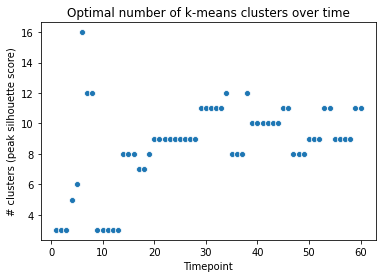

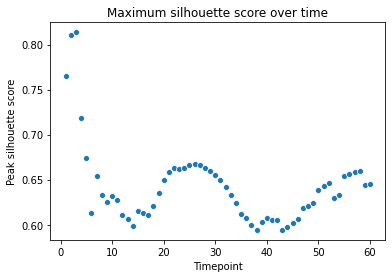

excluding: [2, 10, 1, 11]


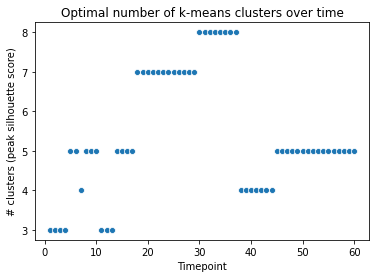

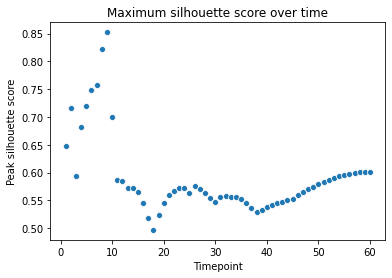

In [0]:
for excidx in range(len(exc)):
  print("excluding:",exc[excidx])
  # plot cluster number
  ax = sns.scatterplot(x=timepts,y=maxclustnum[excidx])
  ax.set(xlabel='Timepoint', ylabel='# clusters (peak silhouette score)')
  plt.title('Optimal number of k-means clusters over time')
  plt.show()
  # plot silhouette score
  ax = sns.scatterplot(x=timepts,y=maxsil[excidx])
  ax.set(xlabel='Timepoint', ylabel='Peak silhouette score')
  plt.title('Maximum silhouette score over time')
  plt.show()

### more analytes

In [0]:
moreandir = "05_01_2020___CSV_SimulatedData_MoreAnalytes"

In [0]:
!unzip "drive/My Drive/CPCB 1/cellsys/05_01_2020___CSV_SimulatedData_MoreAnalytes.zip"

In [0]:
'''
Combine the files into one CSV.
'''

import os
import glob
from natsort import natsorted, ns

combinedfn = "combined_asfeatures_moreanalytes.csv"

# match pattern 'csv'
all_filenames_more = [i for i in glob.glob(moreandir+'/*.{}'.format('csv'))]
all_filenames_more = natsorted(all_filenames_more, alg=ns.IGNORECASE)
# read in csv
all_csv = [pd.read_csv(f,index_col=0) for f in all_filenames_more ]
# prepend fn to colnames
for i in range(len(all_csv)):
  df = all_csv[i]
  prefix = os.path.splitext(os.path.basename(all_filenames_more[i]))[0]
  df.columns = [prefix+"_"+cn for cn in df.columns]
# concatenate
combined_csv = pd.concat(all_csv,axis='columns')
# export to csv
combined_csv.to_csv(combinedfn)

all_basenames_more = [os.path.splitext(os.path.basename(n))[0] for n in all_filenames_more]

# dataframe with all the data
alltimeptsdf = pd.read_csv(combinedfn,index_col=0)

### violin over time

In [0]:
def violin_over_time(extractname, alltimeptsdf, subsetnums, info, showplots=False):
  # extract the analyte columns
  dfext = alltimeptsdf.loc[:,[extractname in c for c in alltimeptsdf.columns]]
  # exclude some swaps
  dfsub = subsetdfbynums(subsetnums,dfext,info)
  dfsub.columns = [c.split("_")[1] for c in dfsub.columns]
  # melt the dataframe
  dfplotlong = dfsub.melt()
  dfplotlong["timept"] = [int(x) for x in dfplotlong['variable']]
  dfplotlong["log10(value)"] = np.log10(dfplotlong["value"])
  # plot violin
  halfn = int(dfplotlong.shape[0]/2)
  fgsz = (15,5)
  title = "Distribution of "+extractname+" over time"
  Path("plots/violin").mkdir(parents=True, exist_ok=True)
  pngprefix = "plots/violin/"+extractname
  # first half
  plt.figure(figsize=fgsz)
  ax = sns.violinplot(x="timept", y="log10(value)", data=dfplotlong[:halfn])
  plt.title(title)
  plt.savefig(pngprefix+"_half1"+".png")
  plt.show() if showplots else plt.clf()
  # second half
  plt.figure(figsize=fgsz)
  ax = sns.violinplot(x="timept", y="log10(value)", data=dfplotlong[halfn:])
  plt.title(title)
  plt.savefig(pngprefix+"_half2"+".png")
  plt.show() if showplots else plt.clf()
  # all
  plt.figure(figsize=fgsz)
  ax = sns.violinplot(x="timept", y="log10(value)", data=dfplotlong)
  plt.title(title)
  plt.savefig(pngprefix+"_all"+".png")
  plt.show() if showplots else plt.clf()

In [0]:
for extname in [x.split("_")[-1] for x in df.columns]:
  violin_over_time(extname, alltimeptsdf, exc[1], info=infodf, showplots=False)

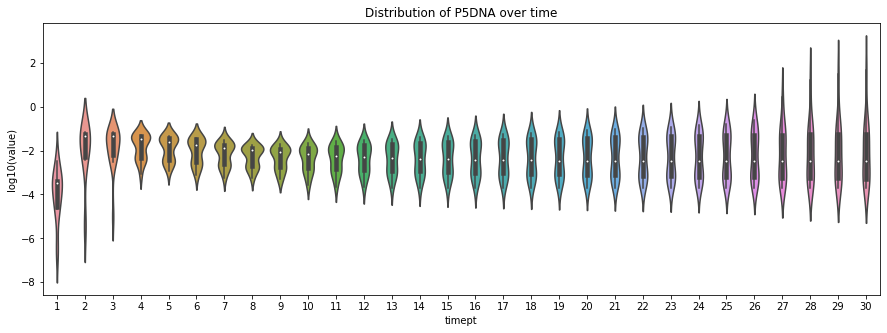

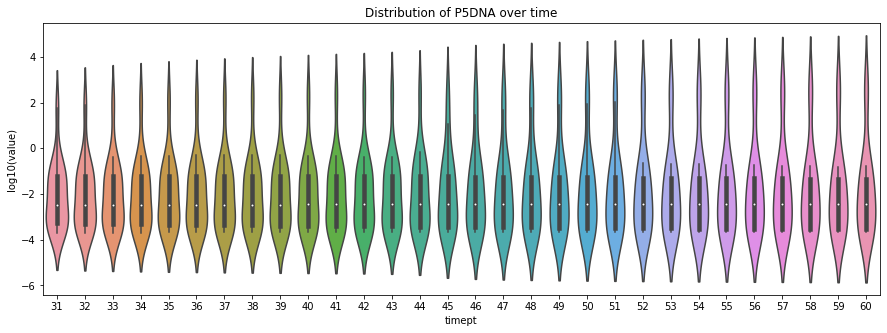

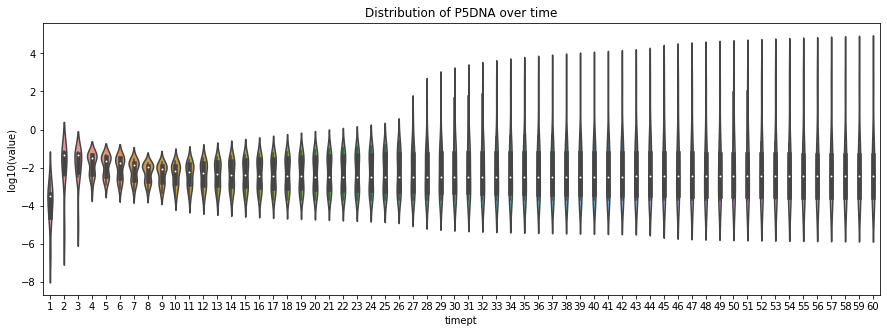

In [20]:
# example
violin_over_time("P5DNA",alltimeptsdf,[1,2,10,11],infodf,showplots=True)

In [0]:
!zip violin.zip plots/violin/*

# trajectory

## tslearn

In [0]:
!pip install tslearn
import tslearn

In [0]:
excidx = 1
dflist = []
for i in trange(len(all_filenames)):
  df = pd.read_csv(all_filenames[i],index_col=0)
  subdf = subsetdfbynums(exc[excidx], df, infodf)
  dflist.append(subdf)
X = np.stack(dflist,axis=1)
X.shape

(17, 60, 17)

In [0]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=klist[excidx], metric="euclidean", 
                      random_state=0).fit(X)
print(km.cluster_centers_.shape)
km_dba = TimeSeriesKMeans(n_clusters=klist[excidx], metric="dtw", 
                          random_state=0).fit(X)
print(km_dba.cluster_centers_.shape)
km_sdtw = TimeSeriesKMeans(n_clusters=klist[excidx], metric="softdtw", 
                           random_state=0).fit(X)
print(km_sdtw.cluster_centers_.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


(5, 60, 17)
(5, 60, 17)
(5, 60, 17)


Counter({3: 8, 4: 3, 1: 3, 0: 2, 2: 1})
(17, 2)


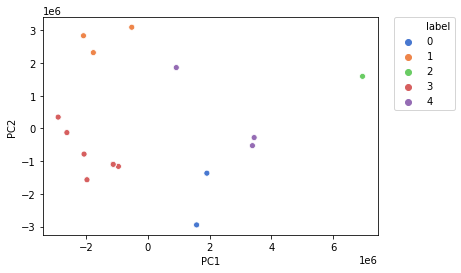

Counter({3: 8, 4: 3, 1: 3, 0: 2, 2: 1})
(17, 2)


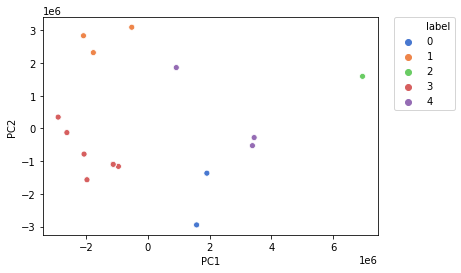

Counter({3: 8, 4: 3, 1: 3, 0: 2, 2: 1})
(17, 2)


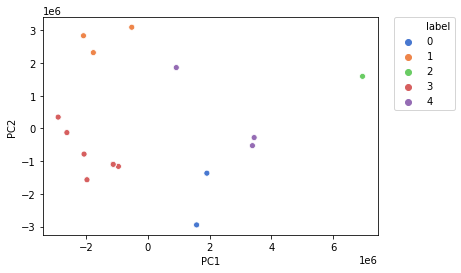

Counter({0: 8, 2: 4, 1: 2, 4: 2, 3: 1})
(17, 2)


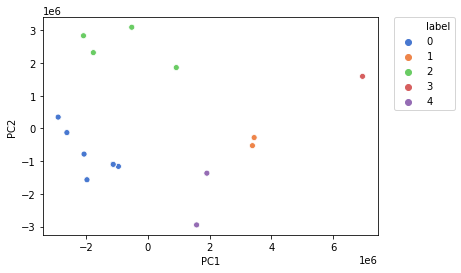

In [0]:
subcluster(finaldf, infodf, exc[excidx], k=10, labs=km.labels_, dims=2, justplot=True)
subcluster(finaldf, infodf, exc[excidx], k=10, labs=km_dba.labels_, dims=2, justplot=True)
subcluster(finaldf, infodf, exc[excidx], k=10, labs=km_sdtw.labels_, dims=2, justplot=True)
l, s, r = subcluster(finaldf, infodf, exc[excidx], k=klist[excidx], dims=2)